In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [2]:
# Load the datasets
train_df = pd.read_csv('../Data/Heart_Failure_Training_Set.csv')
test_df = pd.read_csv('../Data/Test_Set_NO_LABELS.csv')

In [7]:
train_df.head()

,Patient_ID,Gender,Admission Year,Age At Admission,Length of Stay (Days),Primary Insurance,First Potassium Days From Admit,First Potassium Result,Last Potassium Days From Admit,Last Potassium Result,...,Hx_Vent,Hx_Cath,Hx_Renal_Failure,Hx_Pvd,Hx_Valve_Procedure,Hx_Dm,Hx_Ckd,Hx_Ihd,Hx_Aortic_Valve_Problem,Hx_Prior_Admit
0,1616,FEMALE,2020,89.039440,6.008976,TBD,0.150694,3.0,5.616078,4.0,...,False,False,False,False,False,False,False,False,False,False
1,5717,MALE,2020,69.429830,2.596738,TBD,0.112500,3.9,2.358333,4.1,...,False,False,False,False,False,True,False,False,False,True
2,5922,MALE,2019,67.465759,2.046528,TBD,NaN,NaN,NaN,NaN,...,False,False,False,False,False,True,True,False,False,True
3,2054,FEMALE,2019,61.347314,1.644444,TBD,0.033941,4.2,0.055349,3.9,...,False,False,True,False,False,True,True,False,False,True
4,5810,MALE,2019,83.347254,2.253531,TBD,0.278472,4.7,1.738194,3.8,...,False,False,False,False,False,True,False,False,False,True


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5914 entries, 0 to 5913
Data columns (total 95 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Patient_ID                              5914 non-null   int64  
 1   Gender                                  5914 non-null   object 
 2   Admission Year                          5914 non-null   int64  
 3   Age At Admission                        5914 non-null   float64
 4   Length of Stay (Days)                   5914 non-null   float64
 5   Primary Insurance                       5662 non-null   object 
 6   First Potassium Days From Admit         5676 non-null   float64
 7   First Potassium Result                  5673 non-null   float64
 8   Last Potassium Days From Admit          5675 non-null   float64
 9   Last Potassium Result                   5673 non-null   float64
 10  Min Potassium Days From Admit           5677 non-null   floa

In [9]:
train_df.describe()

,Patient_ID,Admission Year,Age At Admission,Length of Stay (Days),First Potassium Days From Admit,First Potassium Result,Last Potassium Days From Admit,Last Potassium Result,Min Potassium Days From Admit,Min Potassium Result,...,First Troponin I Result,First Troponin I Days From Admit,Last Troponin I Result,Last Troponin I Days From Admit,Age at Last Echo,Last Ejection Fraction,Number of ED Vists in Last 6 mo,Total LOS Admitted in Last Year,Number of Admission Last Year,Number of Outpatient Visits Last Year
count,5914.000000,5914.000000,5914.000000,5914.000000,5676.000000,5673.000000,5675.000000,5673.000000,5677.000000,5676.000000,...,472.000000,480.000000,475.000000,477.000000,3044.000000,3045.000000,5914.000000,3511.000000,5914.000000,5914.000000
mean,3780.859993,2019.917991,73.494179,5.106692,0.549111,4.118375,4.534423,4.066078,2.380642,3.713576,...,0.135739,0.396421,0.130785,1.014608,72.544340,48.827323,1.694285,13.241405,1.397700,10.417146
std,2134.652590,0.800518,11.718200,4.211660,0.491168,0.655828,4.220697,0.508575,2.852668,0.496027,...,0.427533,0.820821,0.355863,2.182910,11.231180,18.883717,1.759383,15.012211,1.860454,13.818506
min,77.000000,2019.000000,50.021397,0.003373,0.000672,2.299538,0.002752,2.700000,0.002023,1.695617,...,0.027000,0.001252,0.027000,0.001389,39.781786,2.000000,0.000000,0.084757,0.000000,0.000000
25%,1931.500000,2019.000000,64.111385,2.498020,0.202025,3.700000,1.842861,3.700000,0.713434,3.400000,...,0.030000,0.101389,0.030000,0.245627,63.422584,33.000000,1.000000,4.168223,0.000000,1.000000
50%,3790.500000,2020.000000,73.543326,3.942073,0.465278,4.000000,3.384028,4.000000,1.529095,3.700000,...,0.050000,0.209330,0.050000,0.450845,72.188000,54.000000,1.000000,8.449845,1.000000,6.000000
75%,5645.750000,2021.000000,82.742925,6.361317,0.737500,4.500000,5.743173,4.400000,2.981990,4.000000,...,0.090000,0.352056,0.090000,0.799851,81.422421,65.000000,2.000000,16.394842,2.000000,14.000000
max,7474.000000,2021.000000,104.745503,37.183904,5.915680,7.400815,41.522633,6.703982,37.745524,6.200000,...,5.867295,11.089528,4.096321,26.880909,101.126670,88.100000,20.000000,197.424380,19.000000,176.000000


In [10]:
# Check for missing values
missing_values = train_df.isnull().mean() * 100
print("\
Missing Values in Training Data (%):")
print(missing_values[missing_values > 0].sort_values(ascending=False))

Missing Values in Training Data (%):
First Troponin I Result                   92.018938
Max Troponin I Result                     92.002029
Last Troponin I Result                    91.968211
Last Troponin I Days From Admit           91.934393
First Troponin I Days From Admit          91.883666
                                            ...    
Max Respiritory Rate Result                0.743997
Min Respiritory Rate Days From Admit       0.743997
First Respiritory Rate Days From Admit     0.743997
First Respiritory Rate Result              0.727088
Race Simplified                            0.304363
Length: 73, dtype: float64


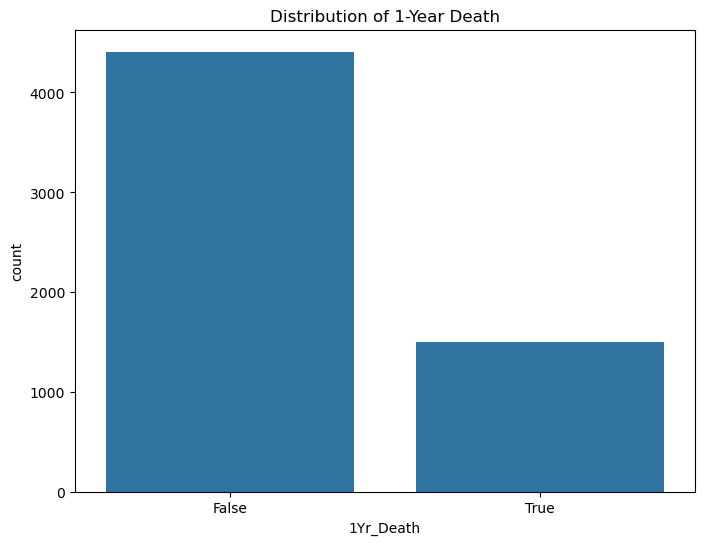

In [11]:
# Visualize the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='1Yr_Death', data=train_df)
plt.title('Distribution of 1-Year Death')
plt.show()

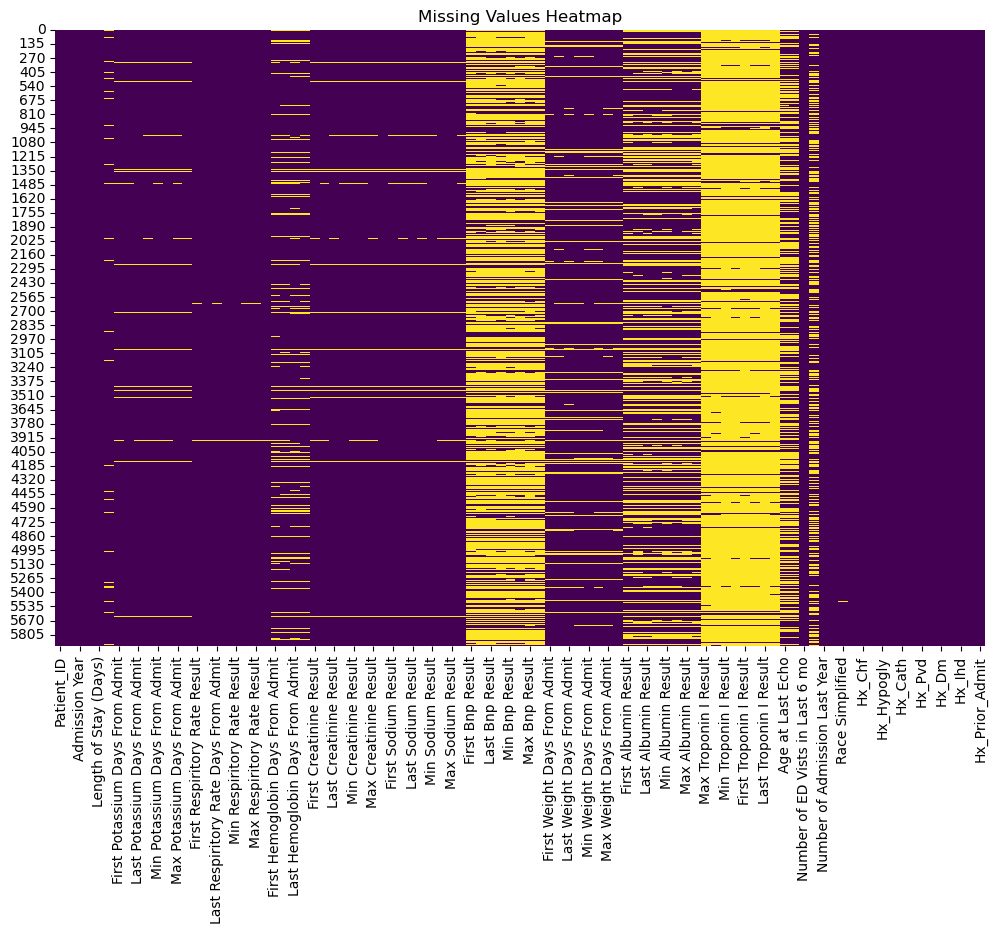

In [12]:
# Visualize missing values
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [13]:
# Remove columns with more than 90% missing values from both datasets
columns_to_drop = missing_values[missing_values > 90].index
train_df_cleaned = train_df.drop(columns=columns_to_drop)
test_df_cleaned = test_df.drop(columns=columns_to_drop)
print("Columns removed due to high percentage of missing values:")
print(columns_to_drop.tolist())

Columns removed due to high percentage of missing values:
['Max Troponin I Result', 'Max Troponin I Days From Admit', 'Min Troponin I Result', 'Min Troponin I Days From Admit', 'First Troponin I Result', 'First Troponin I Days From Admit', 'Last Troponin I Result', 'Last Troponin I Days From Admit']


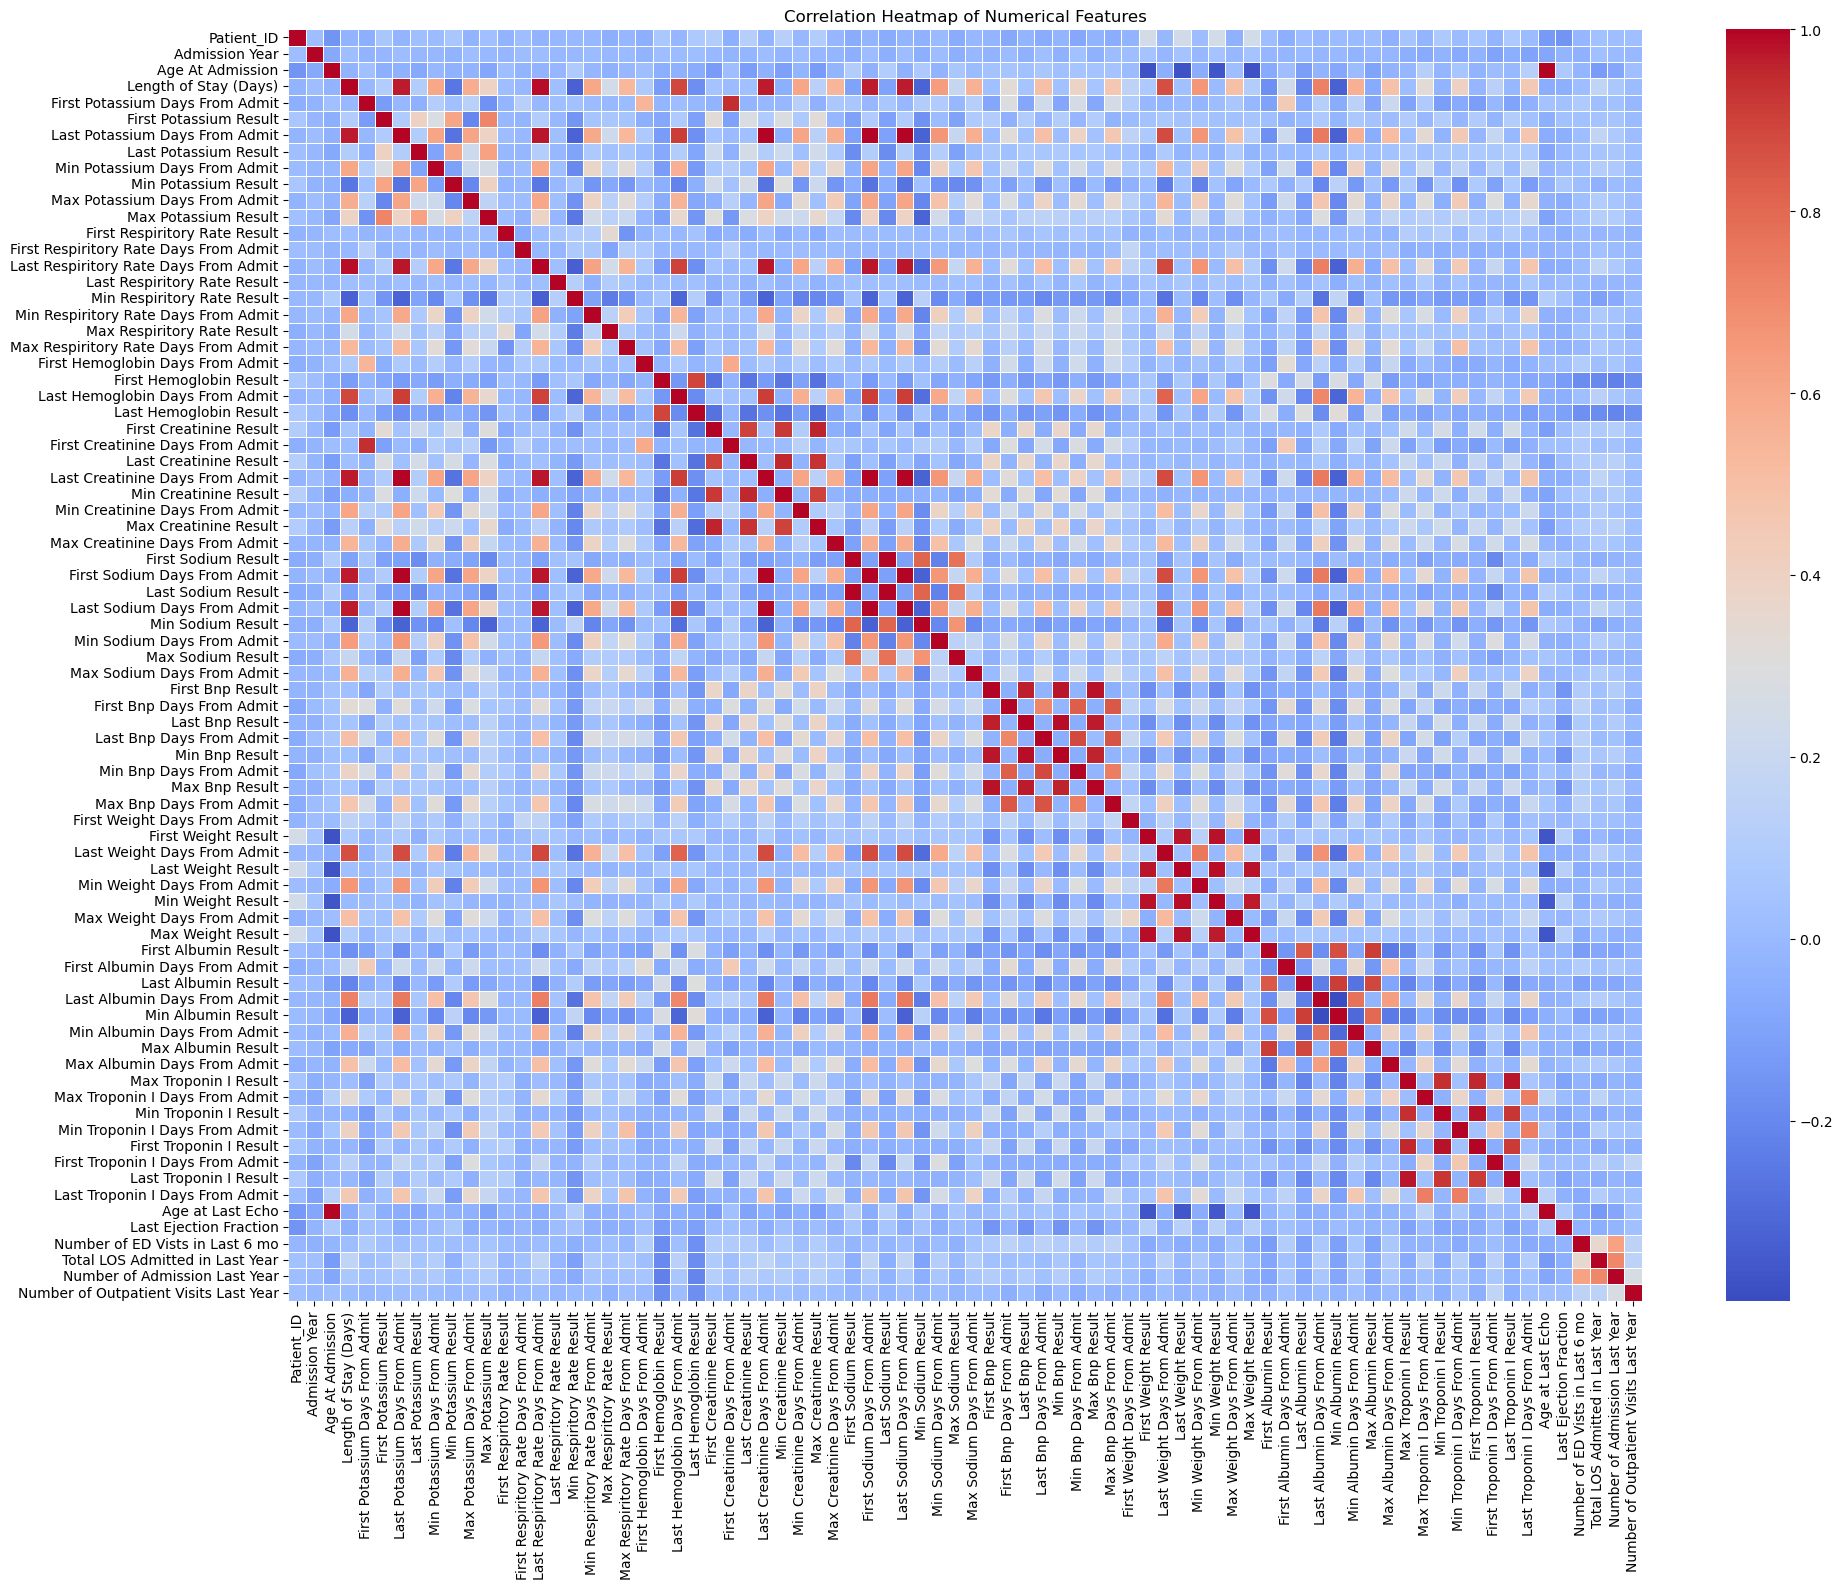

Correlation heatmap saved as 'correlation_heatmap.png'


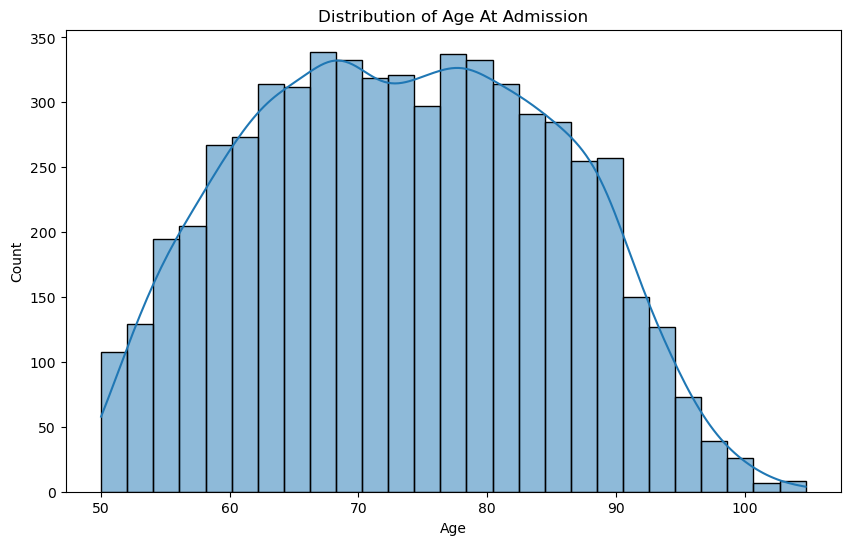

Age distribution plot saved as 'age_distribution.png'


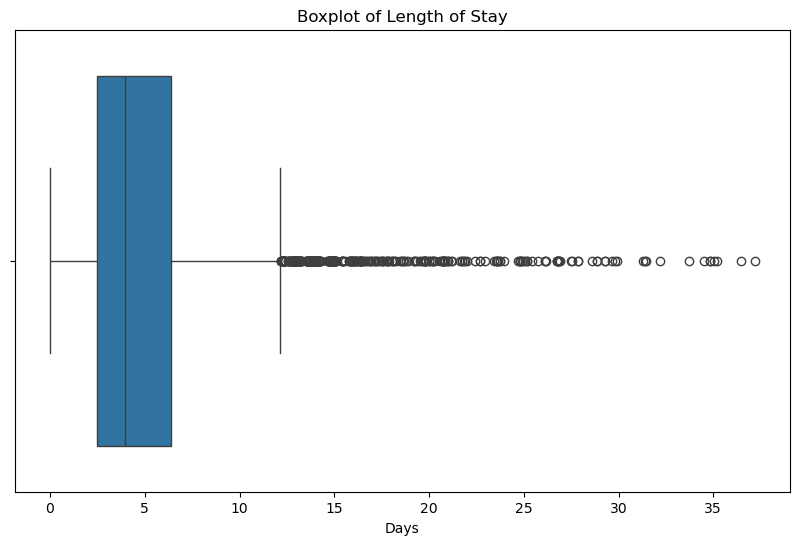

Length of stay boxplot saved as 'length_of_stay_boxplot.png'
Summary Statistics:
       Age At Admission  Length of Stay (Days)  Last Ejection Fraction
count       5914.000000            5914.000000             3045.000000
mean          73.494179               5.106692               48.827323
std           11.718200               4.211660               18.883717
min           50.021397               0.003373                2.000000
25%           64.111385               2.498020               33.000000
50%           73.543326               3.942073               54.000000
75%           82.742925               6.361317               65.000000
max          104.745503              37.183904               88.100000
Top 10 features correlated with Length of Stay:
Length of Stay (Days)                    1.000000
Last Respiritory Rate Days From Admit    0.986564
Last Creatinine Days From Admit          0.968609
Last Potassium Days From Admit           0.967950
Last Sodium Days From Admit     

In [7]:

# Load the dataset
#train_df = pd.read_csv('Heart_Failure_Training_Set.csv')

# Select numerical columns
numerical_columns = train_df.select_dtypes(include=['float64', 'int64']).columns

# Create correlation matrix
correlation_matrix = train_df[numerical_columns].corr()

# Plot correlation heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()
plt.close()

print("Correlation heatmap saved as 'correlation_heatmap.png'")

# Plot distribution of Age At Admission
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Age At Admission'], kde=True)
plt.title('Distribution of Age At Admission')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('age_distribution.png')
plt.show()
plt.close()

print("Age distribution plot saved as 'age_distribution.png'")

# Plot boxplot of Length of Stay
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_df['Length of Stay (Days)'])
plt.title('Boxplot of Length of Stay')
plt.xlabel('Days')
plt.savefig('length_of_stay_boxplot.png')
plt.show()
plt.close()

print("Length of stay boxplot saved as 'length_of_stay_boxplot.png'")

# Calculate and print summary statistics
summary_stats = train_df[['Age At Admission', 'Length of Stay (Days)', 'Last Ejection Fraction']].describe()
print("\
Summary Statistics:")
print(summary_stats)

# Print top 10 correlated features with Length of Stay
correlations = correlation_matrix['Length of Stay (Days)'].sort_values(ascending=False)
print("\
Top 10 features correlated with Length of Stay:")
print(correlations.head(11))  # 11 because it includes the correlation with itself

In [14]:
# Check the new shape of the datasets
print("\
Cleaned Training Data Shape:", train_df_cleaned.shape)
print("Cleaned Test Data Shape:", test_df_cleaned.shape)

Cleaned Training Data Shape: (5914, 87)
Cleaned Test Data Shape: (1479, 86)


In [15]:
# Impute missing values and encode categorical variables

# Function to preprocess data
def preprocess_data(df):
    # Handle missing values
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = df.select_dtypes(include=['object']).columns
    
    numeric_imputer = SimpleImputer(strategy='mean')
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    
    df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])
    df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])
    
    # Encode categorical variables
    le = LabelEncoder()
    for col in categorical_columns:
        df[col] = le.fit_transform(df[col].astype(str))
    
    return df

In [16]:
# Preprocess both datasets
X_train_cleaned = preprocess_data(train_df_cleaned.drop('1Yr_Death', axis=1))
y_train_cleaned = train_df_cleaned['1Yr_Death']
X_test_cleaned = preprocess_data(test_df_cleaned)

print("Preprocessing complete.")
print("\
First few rows of preprocessed training data:")
X_train_cleaned.head()

Preprocessing complete.
First few rows of preprocessed training data:


,Patient_ID,Gender,Admission Year,Age At Admission,Length of Stay (Days),Primary Insurance,First Potassium Days From Admit,First Potassium Result,Last Potassium Days From Admit,Last Potassium Result,...,Hx_Vent,Hx_Cath,Hx_Renal_Failure,Hx_Pvd,Hx_Valve_Procedure,Hx_Dm,Hx_Ckd,Hx_Ihd,Hx_Aortic_Valve_Problem,Hx_Prior_Admit
0,1616.0,0,2020.0,89.039440,6.008976,0,0.150694,3.000000,5.616078,4.000000,...,False,False,False,False,False,False,False,False,False,False
1,5717.0,1,2020.0,69.429830,2.596738,0,0.112500,3.900000,2.358333,4.100000,...,False,False,False,False,False,True,False,False,False,True
2,5922.0,1,2019.0,67.465759,2.046528,0,0.549111,4.118375,4.534423,4.066078,...,False,False,False,False,False,True,True,False,False,True
3,2054.0,0,2019.0,61.347314,1.644444,0,0.033941,4.200000,0.055349,3.900000,...,False,False,True,False,False,True,True,False,False,True
4,5810.0,1,2019.0,83.347254,2.253531,0,0.278472,4.700000,1.738194,3.800000,...,False,False,False,False,False,True,False,False,False,True


In [17]:
print("\
First few rows of preprocessed test data:")
X_test_cleaned.head()

First few rows of preprocessed test data:


,Patient_ID,Gender,Admission Year,Age At Admission,Length of Stay (Days),Primary Insurance,First Potassium Days From Admit,First Potassium Result,Last Potassium Days From Admit,Last Potassium Result,...,Hx_Vent,Hx_Cath,Hx_Renal_Failure,Hx_Pvd,Hx_Valve_Procedure,Hx_Dm,Hx_Ckd,Hx_Ihd,Hx_Aortic_Valve_Problem,Hx_Prior_Admit
0,85.0,0,2019.0,75.761482,5.818750,0,1.090278,4.1,7.388618,4.0,...,False,False,False,True,False,False,True,False,False,True
1,89.0,0,2020.0,50.325190,0.906011,0,0.295833,4.2,0.433250,4.3,...,False,False,False,False,False,False,False,False,False,True
2,90.0,0,2020.0,67.305105,6.537992,0,0.688603,3.0,5.863145,4.0,...,False,False,False,True,False,False,True,False,False,True
3,98.0,0,2020.0,86.082575,1.062054,0,0.441667,4.8,0.790984,4.9,...,False,False,False,False,False,False,False,False,False,False
4,107.0,0,2019.0,66.974902,12.316098,0,0.098213,4.4,11.804439,4.3,...,True,False,False,False,False,True,False,True,True,False


In [31]:
# Initialize models
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)

# Perform cross-validation
rf_scores = cross_val_score(rf_model, X_train_cleaned, y_train_cleaned, cv=5, scoring='roc_auc')
gb_scores = cross_val_score(gb_model, X_train_cleaned, y_train_cleaned, cv=5, scoring='roc_auc')

In [32]:
# Print results
print("Random Forest CV Scores:", rf_scores)
print("Random Forest Mean AUC:", rf_scores.mean())

Random Forest CV Scores: [0.68778486 0.70044862 0.68205377 0.68349078 0.67729025]
Random Forest Mean AUC: 0.6862136566697552


In [33]:
print("\
Gradient Boosting CV Scores:", gb_scores)
print("Gradient Boosting Mean AUC:", gb_scores.mean())

Gradient Boosting CV Scores: [0.71662109 0.73211743 0.70814971 0.69749738 0.70164021]
Gradient Boosting Mean AUC: 0.711205163940807


In [34]:
# Train the best model on the full training set
best_model = GradientBoostingClassifier(random_state=42)
best_model.fit(X_train_cleaned, y_train_cleaned)

GradientBoostingClassifier(random_state=42)

In [35]:
# Make predictions on the test set
test_probs = best_model.predict_proba(X_test_cleaned)[:, 1]

In [36]:
# Create output dataframe
output_df = pd.DataFrame({
    'Person_id': test_df_cleaned['Patient_ID'],
    'Predicted probability': np.round(test_probs, 2)
})

In [37]:
print("\
First few rows of predictions:")
output_df.head()

First few rows of predictions:


,Person_id,Predicted probability
0,85.0,0.30
1,89.0,0.08
2,90.0,0.36
3,98.0,0.22
4,107.0,0.24


In [38]:
# Save predictions to CSV
output_df.to_csv('heart_failure_predictions.csv', index=False)
print("\
Predictions saved to 'heart_failure_predictions.csv'")

Predictions saved to 'heart_failure_predictions.csv'


# Improving the Model Performance

In [40]:
# Calculate permutation importance
perm_importance = permutation_importance(best_model, X_train_cleaned, y_train_cleaned, n_repeats=30, random_state=42)

# Create a DataFrame for permutation importance
perm_importance_df = pd.DataFrame({'feature': X_train_cleaned.columns, 'importance': perm_importance.importances_mean})
perm_importance_df = perm_importance_df.sort_values('importance', ascending=False).head(10)

print('\
Top 10 Important Features based on Permutation Importance:')
perm_importance_df

Top 10 Important Features based on Permutation Importance:


,feature,importance
71,Number of Outpatient Visits Last Year,0.012186
68,Number of ED Vists in Last 6 mo,0.008945
69,Total LOS Admitted in Last Year,0.008697
17,Last Respiritory Rate Result,0.008122
3,Age At Admission,0.007649
48,Max Bnp Result,0.006555
25,Last Hemoglobin Result,0.004391
13,Max Potassium Result,0.004317
67,Last Ejection Fraction,0.004261
31,Min Creatinine Days From Admit,0.004205


In [41]:
# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_cleaned, y_train_cleaned)

In [42]:
print("Class distribution after SMOTE:")
pd.Series(y_train_balanced).value_counts()

Class distribution after SMOTE:


1Yr_Death
False    4410
True     4410
Name: count, dtype: int64

In [43]:
# Reduce the number of iterations for RandomizedSearchCV for quicker execution
param_dist = {
    'n_estimators': randint(100, 200),
    'max_depth': randint(3, 7),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'learning_rate': uniform(0.01, 0.1)
}

# Set up RandomizedSearchCV with fewer iterations
random_search = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=param_dist,
    n_iter=20,  # Reduced number of iterations
    cv=3,  # Reduced number of cross-validation folds
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
random_search.fit(X_train_balanced, y_train_balanced)

# Print the best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best ROC AUC score:", random_search.best_score_)

# Train the best model on the full balanced training set
best_gb_model = random_search.best_estimator_
best_gb_model.fit(X_train_balanced, y_train_balanced)

# Make predictions on the test set
test_probs = best_gb_model.predict_proba(X_test_cleaned)[:, 1]

# Create output dataframe
output_df = pd.DataFrame({
    'Person_id': test_df_cleaned['Patient_ID'],
    'Predicted probability': np.round(test_probs, 2)
})

print("\
First few rows of predictions:")
print(output_df.head())

# Save predictions to CSV
output_df.to_csv('heart_failure_predictions_tuned.csv', index=False)
print("\
Predictions saved to 'heart_failure_predictions_tuned.csv'")

Best parameters: {'learning_rate': 0.07183860093330872, 'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 163}
Best ROC AUC score: 0.9028000678729541
First few rows of predictions:
   Person_id  Predicted probability
0       85.0                   0.32
1       89.0                   0.10
2       90.0                   0.35
3       98.0                   0.41
4      107.0                   0.16
Predictions saved to 'heart_failure_predictions_tuned.csv'
